In [9]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import copy
from tqdm import tqdm

# Use GPU if available.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


class LogisticRegression(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(LogisticRegression, self).__init__()
        # Define a single weight parameter.
        self.w = nn.Parameter(torch.randn(input_dim, num_classes))

    def forward(self, x):
        return x @ self.w


def F_alpha_loss(logits, target, model, alpha):
    max_logits = logits.max(dim=1, keepdim=True).values
    log_sum_exp = max_logits + (logits - max_logits).exp().sum(dim=1, keepdim=True).log()
    
    labels = target.unsqueeze(1)
    y_train = torch.zeros_like(logits).scatter(1, labels, 1)

    subtract_term = (y_train * logits).sum(dim=1, keepdim=True)
    loss_data = torch.mean(log_sum_exp - subtract_term)

    alpha_term = 0.5 * alpha * torch.sum(model.w ** 2)

    return loss_data + alpha_term


def compute_gradients(model, data, target, loss_fn, alpha):
    model.zero_grad()
    logits = model(data)
    loss = loss_fn(logits, target, model, alpha)
    loss.backward()
    grads = {name: param.grad.data.clone() for name, param in model.named_parameters()}
    return grads, loss.item()


def train(model, train_loader, test_loader, alpha, lr, input_dim, num_classes, outer_epochs):  
    losses = []
    accuracies = []  
    for _ in tqdm(range(outer_epochs)):        
        model.train()
        snapshot = copy.deepcopy(model.state_dict())
        
        model.load_state_dict(snapshot)
        full_grad = {name: torch.zeros_like(param.data) for name, param in model.named_parameters()}

        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            grads, _ = compute_gradients(model, data, target, F_alpha_loss, alpha)
            for name in grads:
                full_grad[name] += grads[name] * data.size(0)

        num_samples = len(train_loader.dataset)
        for name in full_grad:
            full_grad[name] /= num_samples

        for data, target in train_loader:
            data, target = data.to(device), target.to(device)

            grads_current, _ = compute_gradients(model, data, target, F_alpha_loss, alpha)

            snapshot_model = LogisticRegression(input_dim, num_classes).to(device)
            snapshot_model.load_state_dict(snapshot)
            snapshot_model.train()
            grads_snapshot, _ = compute_gradients(snapshot_model, data, target, F_alpha_loss, alpha)

            with torch.no_grad():
                for name, param in model.named_parameters():
                    update = grads_current[name] - grads_snapshot[name] + full_grad[name]
                    param.data -= lr * update

        test_loss, accuracy = test(model, test_loader, alpha)
        print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {accuracy:.2f}%\n")
        losses.append(test_loss)
        accuracies.append(accuracy)

    return losses, accuracies


def test(model, test_loader, alpha):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            logits = model(data)
            loss = F_alpha_loss(logits, target, model, alpha)
            total_loss += loss.item() * data.size(0)
            predicted = logits.argmax(dim=1)
            correct += (predicted == target).sum().item()
            total += target.size(0)

    avg_loss = total_loss / total
    accuracy = 100.0 * correct / total
    return avg_loss, accuracy


def main():    
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.view(-1))
    ])
    
    train_dataset = torchvision.datasets.MNIST(root='./data', train=True,
                                               transform=transform, download=True)
    test_dataset = torchvision.datasets.MNIST(root='./data', train=False,
                                              transform=transform, download=True)

    batch_size = 128
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)
    
    input_dim = 28 * 28
    num_classes = 10
    model = LogisticRegression(input_dim, num_classes).to(device)

    outer_epochs = 20  # Number of outer epochs.
    lr = 0.1         # Learning rate.    
    
    alpha_range = [0, 0.0001, 0.005, 0.01, 0.025]#, 0.05, 0.1, 1.0]
    
    d_alpha_losses = {}
    d_alpha_acc = {}
    for alpha in alpha_range:
        print("Alpha = ", alpha)
        losses, accuracies = train(model, train_loader, test_loader, alpha, lr, input_dim, num_classes, outer_epochs)
        d_alpha_losses[alpha] = losses
        d_alpha_acc[alpha] = accuracies

    return d_alpha_acc, d_alpha_losses


In [10]:
if __name__ == "__main__":
    result = main()

Alpha =  0


  5%|▌         | 1/20 [00:19<06:05, 19.22s/it]

Test Loss: 1.2195, Test Accuracy: 74.66%



 10%|█         | 2/20 [00:35<05:14, 17.45s/it]

Test Loss: 0.9059, Test Accuracy: 80.34%



 15%|█▌        | 3/20 [00:51<04:47, 16.92s/it]

Test Loss: 0.7822, Test Accuracy: 82.88%



 20%|██        | 4/20 [01:08<04:27, 16.70s/it]

Test Loss: 0.7113, Test Accuracy: 84.15%



 25%|██▌       | 5/20 [01:24<04:08, 16.55s/it]

Test Loss: 0.6635, Test Accuracy: 85.14%



 30%|███       | 6/20 [01:42<04:01, 17.25s/it]

Test Loss: 0.6282, Test Accuracy: 85.72%



 35%|███▌      | 7/20 [02:00<03:44, 17.29s/it]

Test Loss: 0.6007, Test Accuracy: 86.19%



 40%|████      | 8/20 [02:18<03:30, 17.57s/it]

Test Loss: 0.5785, Test Accuracy: 86.67%



 45%|████▌     | 9/20 [02:35<03:12, 17.48s/it]

Test Loss: 0.5599, Test Accuracy: 87.00%



 50%|█████     | 10/20 [02:52<02:53, 17.36s/it]

Test Loss: 0.5442, Test Accuracy: 87.29%



 55%|█████▌    | 11/20 [03:09<02:35, 17.28s/it]

Test Loss: 0.5305, Test Accuracy: 87.49%



 60%|██████    | 12/20 [03:27<02:17, 17.24s/it]

Test Loss: 0.5186, Test Accuracy: 87.68%



 65%|██████▌   | 13/20 [03:44<02:00, 17.21s/it]

Test Loss: 0.5080, Test Accuracy: 87.83%



 70%|███████   | 14/20 [04:01<01:42, 17.16s/it]

Test Loss: 0.4984, Test Accuracy: 87.95%



 75%|███████▌  | 15/20 [04:18<01:25, 17.16s/it]

Test Loss: 0.4897, Test Accuracy: 88.10%



 80%|████████  | 16/20 [04:35<01:08, 17.16s/it]

Test Loss: 0.4819, Test Accuracy: 88.19%



 85%|████████▌ | 17/20 [04:52<00:51, 17.15s/it]

Test Loss: 0.4746, Test Accuracy: 88.26%



 90%|█████████ | 18/20 [05:09<00:34, 17.12s/it]

Test Loss: 0.4679, Test Accuracy: 88.41%



 95%|█████████▌| 19/20 [05:26<00:17, 17.09s/it]

Test Loss: 0.4617, Test Accuracy: 88.53%



100%|██████████| 20/20 [05:43<00:00, 17.19s/it]


Test Loss: 0.4560, Test Accuracy: 88.61%

Alpha =  0.0001


  5%|▌         | 1/20 [00:17<05:25, 17.13s/it]

Test Loss: 0.7898, Test Accuracy: 88.74%



 10%|█         | 2/20 [00:34<05:06, 17.05s/it]

Test Loss: 0.7793, Test Accuracy: 88.88%



 15%|█▌        | 3/20 [00:51<04:50, 17.09s/it]

Test Loss: 0.7691, Test Accuracy: 88.94%



 20%|██        | 4/20 [01:08<04:33, 17.08s/it]

Test Loss: 0.7594, Test Accuracy: 89.01%



 25%|██▌       | 5/20 [01:25<04:17, 17.17s/it]

Test Loss: 0.7500, Test Accuracy: 89.10%



 30%|███       | 6/20 [01:42<03:59, 17.14s/it]

Test Loss: 0.7410, Test Accuracy: 89.21%



 35%|███▌      | 7/20 [02:00<03:44, 17.28s/it]

Test Loss: 0.7323, Test Accuracy: 89.29%



 40%|████      | 8/20 [02:18<03:29, 17.43s/it]

Test Loss: 0.7239, Test Accuracy: 89.36%



 45%|████▌     | 9/20 [02:34<03:08, 17.17s/it]

Test Loss: 0.7157, Test Accuracy: 89.43%



 50%|█████     | 10/20 [02:51<02:52, 17.21s/it]

Test Loss: 0.7079, Test Accuracy: 89.50%



 55%|█████▌    | 11/20 [03:08<02:33, 17.04s/it]

Test Loss: 0.7003, Test Accuracy: 89.59%



 60%|██████    | 12/20 [03:25<02:15, 16.96s/it]

Test Loss: 0.6929, Test Accuracy: 89.68%



 65%|██████▌   | 13/20 [03:42<01:58, 16.89s/it]

Test Loss: 0.6857, Test Accuracy: 89.79%



 70%|███████   | 14/20 [03:58<01:40, 16.82s/it]

Test Loss: 0.6788, Test Accuracy: 89.86%



 75%|███████▌  | 15/20 [04:15<01:24, 16.82s/it]

Test Loss: 0.6721, Test Accuracy: 89.89%



 80%|████████  | 16/20 [04:32<01:07, 16.88s/it]

Test Loss: 0.6655, Test Accuracy: 89.89%



 85%|████████▌ | 17/20 [04:49<00:51, 17.03s/it]

Test Loss: 0.6591, Test Accuracy: 90.00%



 90%|█████████ | 18/20 [05:08<00:34, 17.45s/it]

Test Loss: 0.6529, Test Accuracy: 90.00%



 95%|█████████▌| 19/20 [05:28<00:18, 18.17s/it]

Test Loss: 0.6469, Test Accuracy: 90.02%



100%|██████████| 20/20 [05:47<00:00, 17.39s/it]


Test Loss: 0.6410, Test Accuracy: 90.11%

Alpha =  0.005


  5%|▌         | 1/20 [00:17<05:23, 17.04s/it]

Test Loss: 8.7922, Test Accuracy: 90.14%



 10%|█         | 2/20 [00:34<05:08, 17.16s/it]

Test Loss: 5.6198, Test Accuracy: 90.27%



 15%|█▌        | 3/20 [00:53<05:08, 18.14s/it]

Test Loss: 3.6533, Test Accuracy: 90.65%



 20%|██        | 4/20 [01:11<04:48, 18.06s/it]

Test Loss: 2.4362, Test Accuracy: 90.95%



 25%|██▌       | 5/20 [01:29<04:31, 18.08s/it]

Test Loss: 1.6832, Test Accuracy: 91.19%



 30%|███       | 6/20 [01:46<04:07, 17.68s/it]

Test Loss: 1.2171, Test Accuracy: 91.34%



 35%|███▌      | 7/20 [02:03<03:45, 17.31s/it]

Test Loss: 0.9284, Test Accuracy: 91.34%



 40%|████      | 8/20 [02:19<03:25, 17.11s/it]

Test Loss: 0.7493, Test Accuracy: 91.38%



 45%|████▌     | 9/20 [02:36<03:06, 16.99s/it]

Test Loss: 0.6383, Test Accuracy: 91.31%



 50%|█████     | 10/20 [02:53<02:49, 16.90s/it]

Test Loss: 0.5693, Test Accuracy: 91.30%



 55%|█████▌    | 11/20 [03:10<02:31, 16.88s/it]

Test Loss: 0.5265, Test Accuracy: 91.25%



 60%|██████    | 12/20 [03:26<02:14, 16.83s/it]

Test Loss: 0.4998, Test Accuracy: 91.28%



 65%|██████▌   | 13/20 [03:43<01:56, 16.71s/it]

Test Loss: 0.4832, Test Accuracy: 91.33%



 70%|███████   | 14/20 [03:59<01:39, 16.56s/it]

Test Loss: 0.4728, Test Accuracy: 91.25%



 75%|███████▌  | 15/20 [04:15<01:22, 16.45s/it]

Test Loss: 0.4664, Test Accuracy: 91.26%



 80%|████████  | 16/20 [04:32<01:05, 16.45s/it]

Test Loss: 0.4624, Test Accuracy: 91.23%



 85%|████████▌ | 17/20 [04:48<00:49, 16.45s/it]

Test Loss: 0.4598, Test Accuracy: 91.23%



 90%|█████████ | 18/20 [05:04<00:32, 16.38s/it]

Test Loss: 0.4583, Test Accuracy: 91.22%



 95%|█████████▌| 19/20 [05:20<00:16, 16.34s/it]

Test Loss: 0.4573, Test Accuracy: 91.22%



100%|██████████| 20/20 [05:38<00:00, 16.90s/it]


Test Loss: 0.4567, Test Accuracy: 91.21%

Alpha =  0.01


  5%|▌         | 1/20 [00:16<05:09, 16.29s/it]

Test Loss: 0.5462, Test Accuracy: 90.90%



 10%|█         | 2/20 [00:32<04:55, 16.42s/it]

Test Loss: 0.5426, Test Accuracy: 90.75%



 15%|█▌        | 3/20 [00:49<04:42, 16.60s/it]

Test Loss: 0.5416, Test Accuracy: 90.66%



 20%|██        | 4/20 [01:06<04:29, 16.83s/it]

Test Loss: 0.5411, Test Accuracy: 90.64%



 25%|██▌       | 5/20 [01:23<04:10, 16.71s/it]

Test Loss: 0.5410, Test Accuracy: 90.61%



 30%|███       | 6/20 [01:40<03:56, 16.88s/it]

Test Loss: 0.5409, Test Accuracy: 90.58%



 35%|███▌      | 7/20 [01:56<03:37, 16.73s/it]

Test Loss: 0.5408, Test Accuracy: 90.57%



 40%|████      | 8/20 [02:13<03:19, 16.61s/it]

Test Loss: 0.5408, Test Accuracy: 90.56%



 45%|████▌     | 9/20 [02:31<03:07, 17.03s/it]

Test Loss: 0.5408, Test Accuracy: 90.56%



 50%|█████     | 10/20 [02:48<02:51, 17.16s/it]

Test Loss: 0.5408, Test Accuracy: 90.56%



 55%|█████▌    | 11/20 [03:06<02:35, 17.23s/it]

Test Loss: 0.5408, Test Accuracy: 90.56%



 60%|██████    | 12/20 [03:23<02:17, 17.22s/it]

Test Loss: 0.5408, Test Accuracy: 90.56%



 65%|██████▌   | 13/20 [03:40<02:00, 17.18s/it]

Test Loss: 0.5408, Test Accuracy: 90.56%



 70%|███████   | 14/20 [03:56<01:41, 16.88s/it]

Test Loss: 0.5408, Test Accuracy: 90.56%



 75%|███████▌  | 15/20 [04:12<01:23, 16.70s/it]

Test Loss: 0.5408, Test Accuracy: 90.56%



 80%|████████  | 16/20 [04:29<01:06, 16.62s/it]

Test Loss: 0.5408, Test Accuracy: 90.56%



 85%|████████▌ | 17/20 [04:45<00:49, 16.55s/it]

Test Loss: 0.5408, Test Accuracy: 90.56%



 90%|█████████ | 18/20 [05:02<00:32, 16.50s/it]

Test Loss: 0.5408, Test Accuracy: 90.56%



 95%|█████████▌| 19/20 [05:18<00:16, 16.44s/it]

Test Loss: 0.5408, Test Accuracy: 90.56%



100%|██████████| 20/20 [05:35<00:00, 16.75s/it]


Test Loss: 0.5408, Test Accuracy: 90.56%

Alpha =  0.025


  5%|▌         | 1/20 [00:16<05:14, 16.54s/it]

Test Loss: 0.7039, Test Accuracy: 89.59%



 10%|█         | 2/20 [00:32<04:54, 16.34s/it]

Test Loss: 0.7026, Test Accuracy: 89.32%



 15%|█▌        | 3/20 [00:49<04:37, 16.33s/it]

Test Loss: 0.7025, Test Accuracy: 89.32%



 20%|██        | 4/20 [01:06<04:25, 16.62s/it]

Test Loss: 0.7024, Test Accuracy: 89.30%



 25%|██▌       | 5/20 [01:22<04:08, 16.55s/it]

Test Loss: 0.7024, Test Accuracy: 89.30%



 30%|███       | 6/20 [01:38<03:50, 16.43s/it]

Test Loss: 0.7024, Test Accuracy: 89.30%



 35%|███▌      | 7/20 [01:54<03:32, 16.37s/it]

Test Loss: 0.7024, Test Accuracy: 89.30%



 40%|████      | 8/20 [02:11<03:16, 16.39s/it]

Test Loss: 0.7024, Test Accuracy: 89.30%



 45%|████▌     | 9/20 [02:27<02:59, 16.36s/it]

Test Loss: 0.7024, Test Accuracy: 89.30%



 50%|█████     | 10/20 [02:45<02:48, 16.85s/it]

Test Loss: 0.7024, Test Accuracy: 89.30%



 55%|█████▌    | 11/20 [03:02<02:30, 16.75s/it]

Test Loss: 0.7024, Test Accuracy: 89.30%



 60%|██████    | 12/20 [03:18<02:12, 16.62s/it]

Test Loss: 0.7024, Test Accuracy: 89.30%



 65%|██████▌   | 13/20 [03:34<01:55, 16.57s/it]

Test Loss: 0.7024, Test Accuracy: 89.30%



 70%|███████   | 14/20 [03:51<01:38, 16.49s/it]

Test Loss: 0.7024, Test Accuracy: 89.30%



 75%|███████▌  | 15/20 [04:07<01:22, 16.49s/it]

Test Loss: 0.7024, Test Accuracy: 89.30%



 80%|████████  | 16/20 [04:24<01:05, 16.47s/it]

Test Loss: 0.7024, Test Accuracy: 89.30%



 85%|████████▌ | 17/20 [04:40<00:49, 16.50s/it]

Test Loss: 0.7024, Test Accuracy: 89.30%



 90%|█████████ | 18/20 [04:57<00:33, 16.69s/it]

Test Loss: 0.7024, Test Accuracy: 89.30%



 95%|█████████▌| 19/20 [05:14<00:16, 16.63s/it]

Test Loss: 0.7024, Test Accuracy: 89.30%



100%|██████████| 20/20 [05:30<00:00, 16.53s/it]

Test Loss: 0.7024, Test Accuracy: 89.30%



In [12]:
import matplotlib.pyplot as plt

def generate_plots(alpha_range, num_epochs, d_alpha_losses, d_alpha_accuracy):
    fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharex=True)
    # colors = cm.Blues(np.linspace(0.2, 0.9, len(alpha_range)))
    epochs_range = list(range(num_epochs))    
    for alpha in alpha_range:    
        # \u03b1 for symbol alpha
        axes[0].plot(epochs_range, d_alpha_losses[alpha], label=f'α = {alpha}', marker = "o", linewidth = 2)#, color=color)
        axes[1].plot(epochs_range, d_alpha_accuracy[alpha], label=f'α = {alpha}', marker = "o", linewidth = 2)#, color=color)

    axes[0].set_title('Training Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[0].grid(True)

    axes[1].set_title('Testing Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Loss')
    axes[1].legend()
    axes[1].grid(True)


    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()

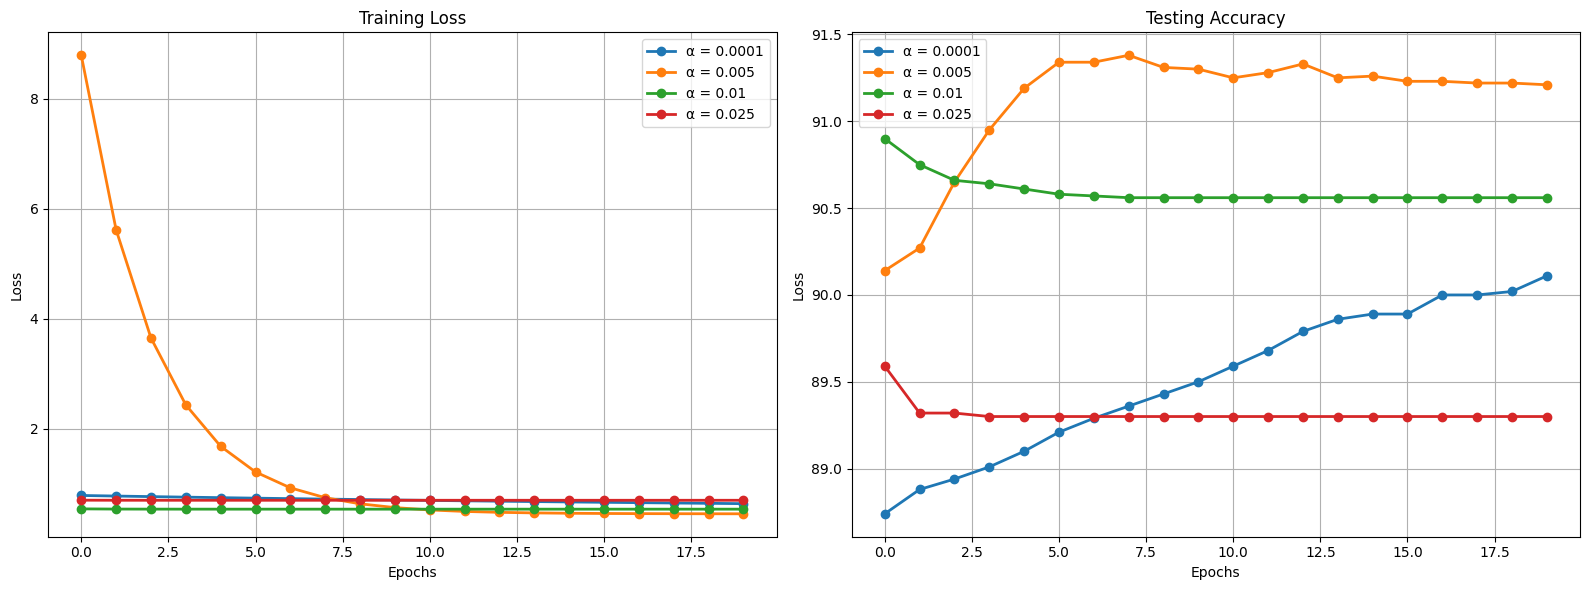

In [17]:
outer_epochs = 20  
alpha_range = [0, 0.0001, 0.005, 0.01, 0.025]#, 0.05, 0.1, 1.0]
d_alpha_accuracy, d_alpha_losses = result
generate_plots(alpha_range[1:], outer_epochs, d_alpha_losses, d_alpha_accuracy)